In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb 

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
store = pd.read_csv('data/store.csv')


In [4]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [6]:
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [7]:
not_open = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("No closed store with sales: " + str(not_open.size == 0))

no_sales = train[(train['Open'] == 1) & (train['Sales'] <= 0)]
print("No open store with no sales: " + str(no_sales.size == 0))

No closed store with sales: True
No open store with no sales: False


In [8]:
train = train.loc[train['Sales'] > 0]

In [16]:
pd.to_datetime(train['Date'])

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1016776   2013-01-01
1016827   2013-01-01
1016863   2013-01-01
1017042   2013-01-01
1017190   2013-01-01
Name: Date, Length: 844338, dtype: datetime64[ns]

In [9]:
dates = pd.to_datetime(train['Date']).sort_values()
dates = dates.unique()
start_date = dates[0]
end_date = dates[-1]
print("Start date: ", start_date)
print("End Date: ", end_date)
date_range = pd.date_range(start_date, end_date).values

Start date:  2013-01-01T00:00:00.000000000
End Date:  2015-07-31T00:00:00.000000000


In [ ]:
for i in range(1, 9):
    data = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter("Day {0}".format(i))
plt.legend()
plt.xlabel('Customer')
plt.xlabel('Sales')
plt.xlabel('Sales
           ')

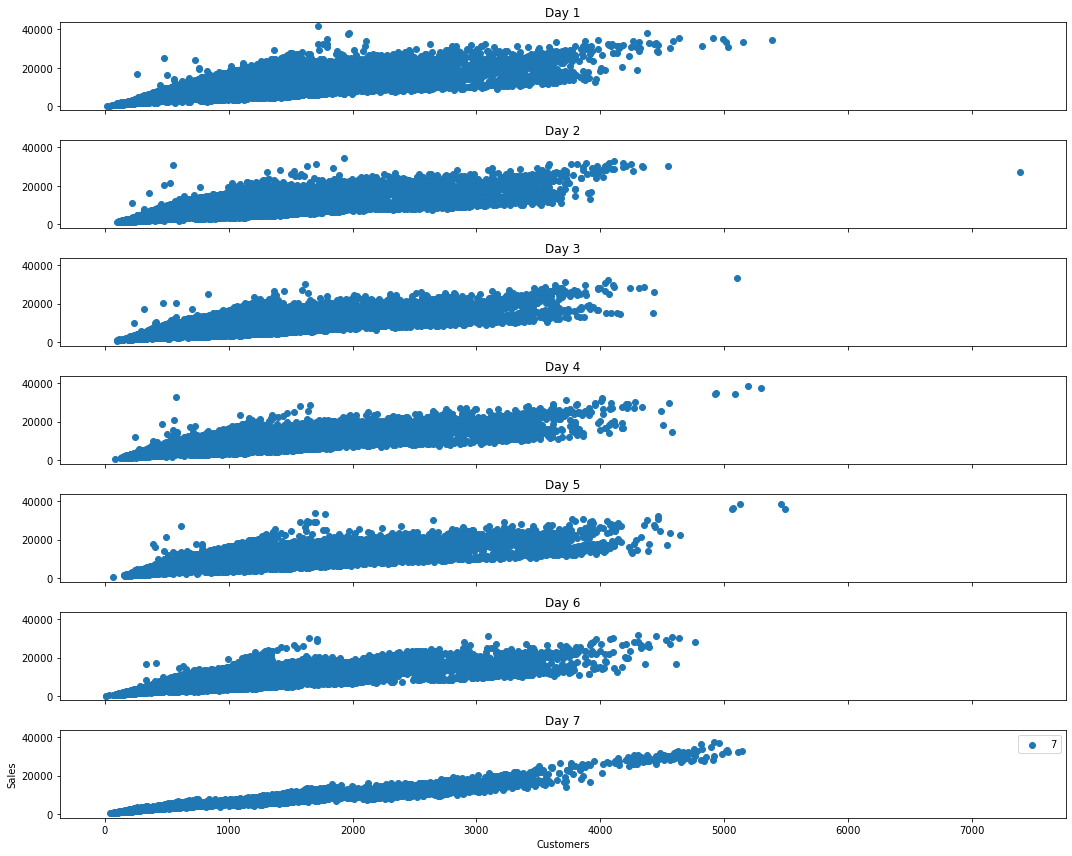

In [15]:
plt.rcParams['figure.figsize'] = (15.0, 12.0)

f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    data = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


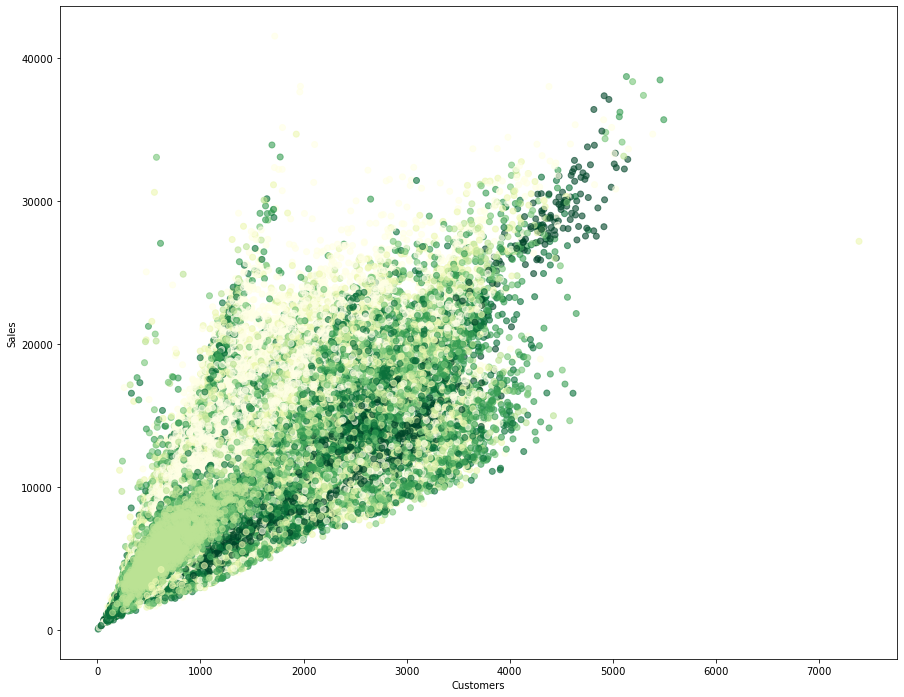

In [21]:
#ploting customer vs sales for each day of week
plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.6, cmap=plt.cm.get_cmap('YlGn'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()


In [24]:
for i in range[0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

TypeError: 'type' object is not subscriptable

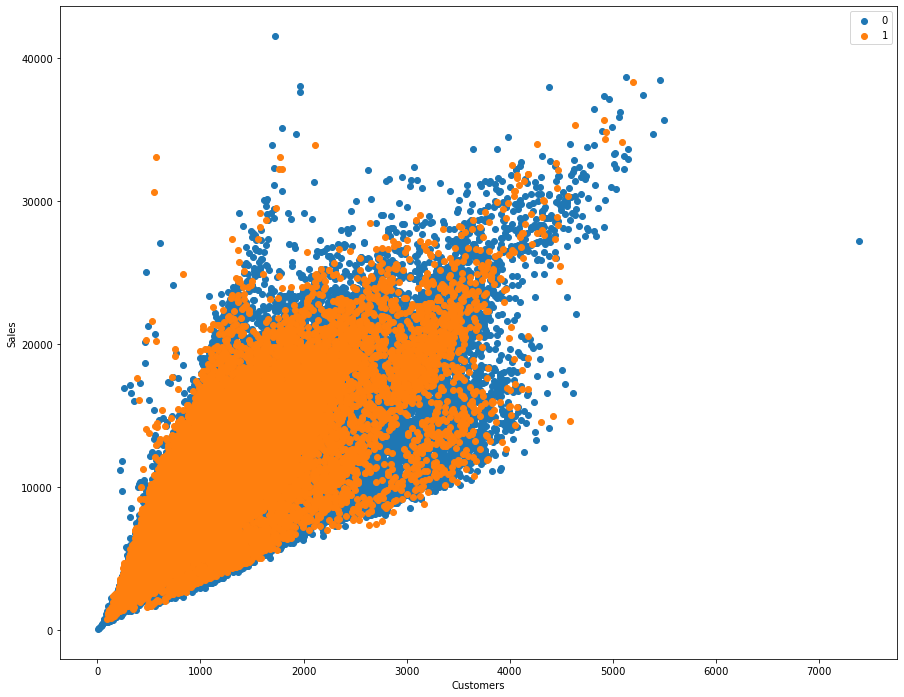

In [23]:
for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [ ]:
DayOfWeek

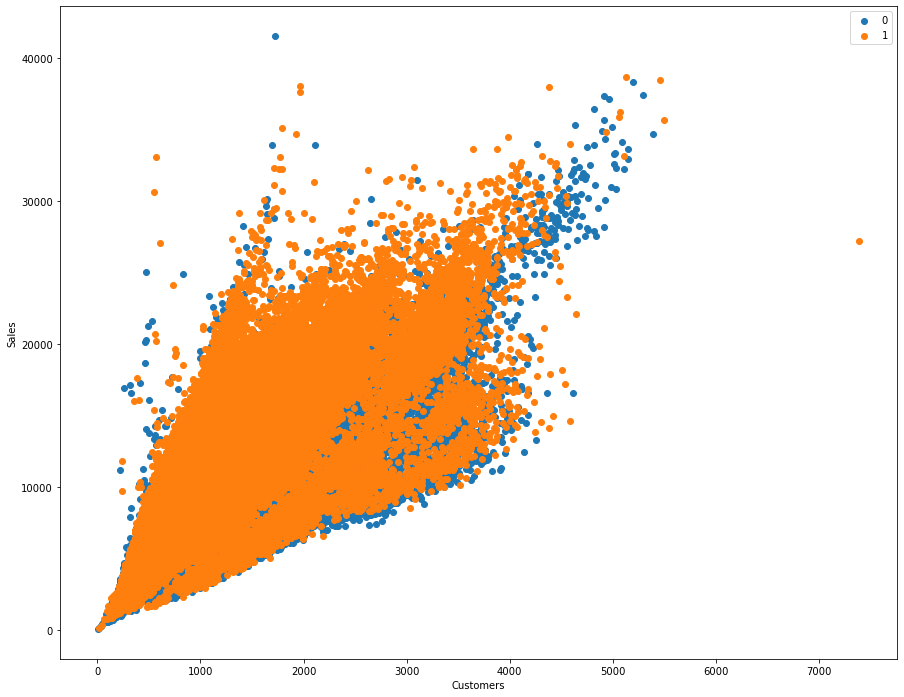

In [25]:
for i in [0, 1]:
    data = train[train['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

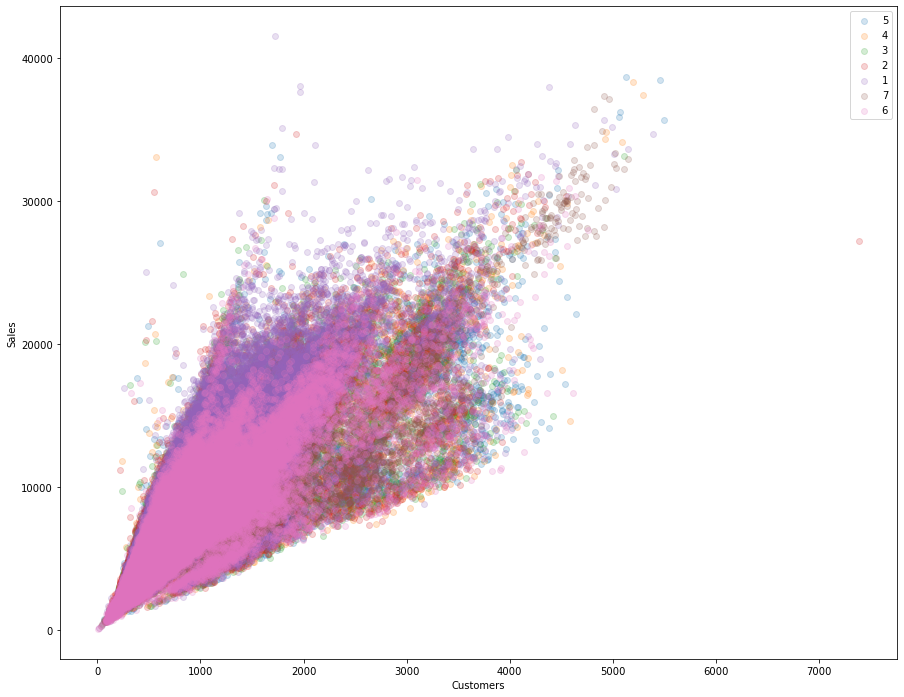

In [30]:
for i in train.DayOfWeek.unique():
    data = train[train['DayOfWeek'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'],data['Sales'], alpha=0.2,label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [31]:
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

avg_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store = pd.merge(avg_store.reset_index(), store, on='Store')
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4759.096031,564.049936,8.393038,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4953.900510,583.998724,8.408443,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6942.568678,750.077022,9.117599,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9638.401786,1321.752551,7.249827,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4676.274711,537.340180,8.611229,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [39]:
store["CompetitionDistance"].fillna(-1000)

0        1270.0
1         570.0
2       14130.0
3         620.0
4       29910.0
         ...   
1110     1900.0
1111     1880.0
1112     9260.0
1113      870.0
1114     5350.0
Name: CompetitionDistance, Length: 1115, dtype: float64

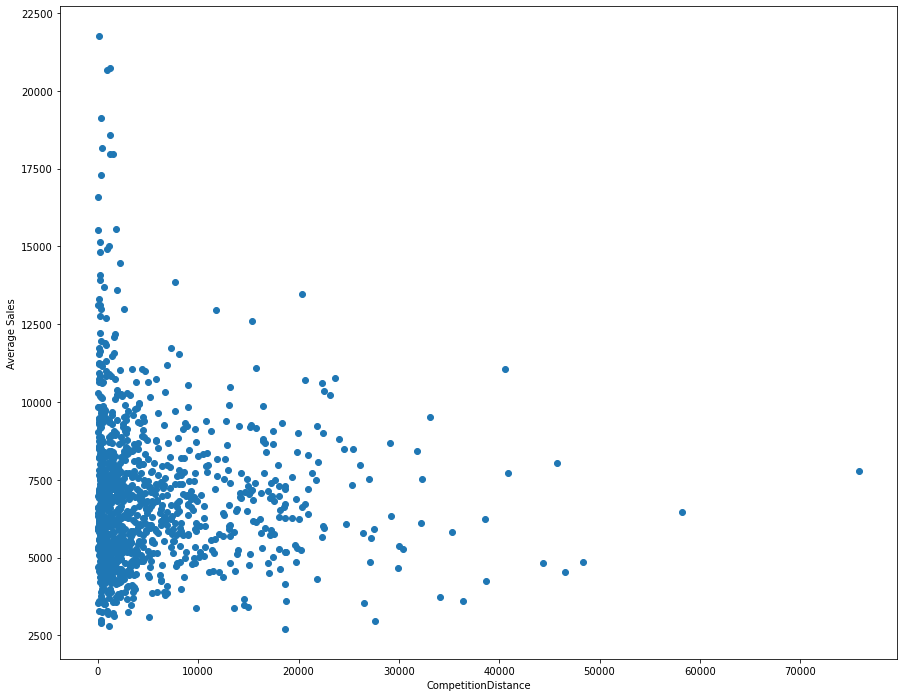

In [35]:


# fill NaN values
store["CompetitionDistance"].fillna(-1)


plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()



In [108]:
store['StoreType'] = store['StoreType'].astype('category').cat.codes
store['Assortment'] = store['Assortment'].astype('category').cat.codes
train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes
store.head()

,Store,MedSales,MedCustomers,MedSalesPerCustomer,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4647.0,550.0,8.362376,4759.096031,564.049936,8.393038,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4783.0,575.5,8.313092,4953.900510,583.998724,8.408443,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6619.0,744.0,9.123440,6942.568678,750.077022,9.117599,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9430.5,1301.5,7.215175,9638.401786,1321.752551,7.249827,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4616.0,564.0,8.584677,4676.274711,537.340180,8.611229,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [109]:
merged = pd.merge(train, store, on='Store', how='left')
merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883,...,8.393038,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,1,1,9.702400,...,8.408443,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,1,1,10.126675,...,9.117599,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,1,1,9.342457,...,7.249827,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,1,1,8.626118,...,8.611229,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [50]:
merged.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
SalesPerCustomer                  0
AvgSales                          0
AvgCustomers                      0
AvgSalesPerCustomer               0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

In [59]:
pd.to_datetime(merged['Date'], format='%Y年%m月%d日 %H時%M分')

0        2015-07-31
1        2015-07-31
2        2015-07-31
3        2015-07-31
4        2015-07-31
            ...    
844333   2013-01-01
844334   2013-01-01
844335   2013-01-01
844336   2013-01-01
844337   2013-01-01
Name: Date, Length: 844338, dtype: datetime64[ns]

In [110]:
merged['Date'] = pd.to_datetime(merged['Date'])


In [66]:
merged.Date.dt.month.sum()

4935809

In [111]:
merged['Year'] = merged.Date.dt.year
merged['Month'] = merged.Date.dt.month
merged['Day'] = merged.Date.dt.day
merged['Week'] = merged.Date.dt.week
merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,1,1,9.702400,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,1,1,10.126675,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,1,1,9.342457,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,1,1,8.626118,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [103]:
# Number of months that competition has existed for
merged['MonthsCompetitionOpen'] = 12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + (merged['Month'] - merged['CompetitionOpenSinceMonth'])
merged.loc[merged['CompetitionOpenSinceYear'] == 0, 'MonthsCompetitionOpen'] = 0


In [104]:
    
    # Number of weeks that promotion has existed for
merged['WeeksPromoOpen'] = 12 * (merged['Year'] - merged['Promo2SinceYear']) + (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
merged.loc[merged['Promo2SinceYear'] == 0, 'WeeksPromoOpen'] = 0

In [112]:
# remove NaNs
merged.fillna(0, inplace=True)

In [113]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  int8          
 8   SchoolHoliday              844338 non-null  int64         
 9   SalesPerCustomer           844338 non-null  float64       
 10  MedSales                   844338 non-null  float64       
 11  MedCustomers               844338 non-null  float64 

In [105]:
toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 
        'Promo2SinceYear', 
        'MonthsCompetitionOpen', 
        'WeeksPromoOpen']

merged[toInt] = merged[toInt].astype(int)


In [106]:
med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

merge = pd.merge(med_store.reset_index(), store, on='Store')


In [107]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   MedSales_x                 1115 non-null   float64
 2   MedCustomers_x             1115 non-null   float64
 3   MedSalesPerCustomer_x      1115 non-null   float64
 4   MedSales_y                 1115 non-null   float64
 5   MedCustomers_y             1115 non-null   float64
 6   MedSalesPerCustomer_y      1115 non-null   float64
 7   AvgSales                   1115 non-null   float64
 8   AvgCustomers               1115 non-null   float64
 9   AvgSalesPerCustomer        1115 non-null   float64
 10  StoreType                  1115 non-null   int8   
 11  Assortment                 1115 non-null   int8   
 12  CompetitionDistance        1112 non-null   float64
 13  CompetitionOpenSinceMonth  761 non-null    float

In [85]:
import seaborn as sns

<AxesSubplot:xlabel='Store', ylabel='AvgSales'>

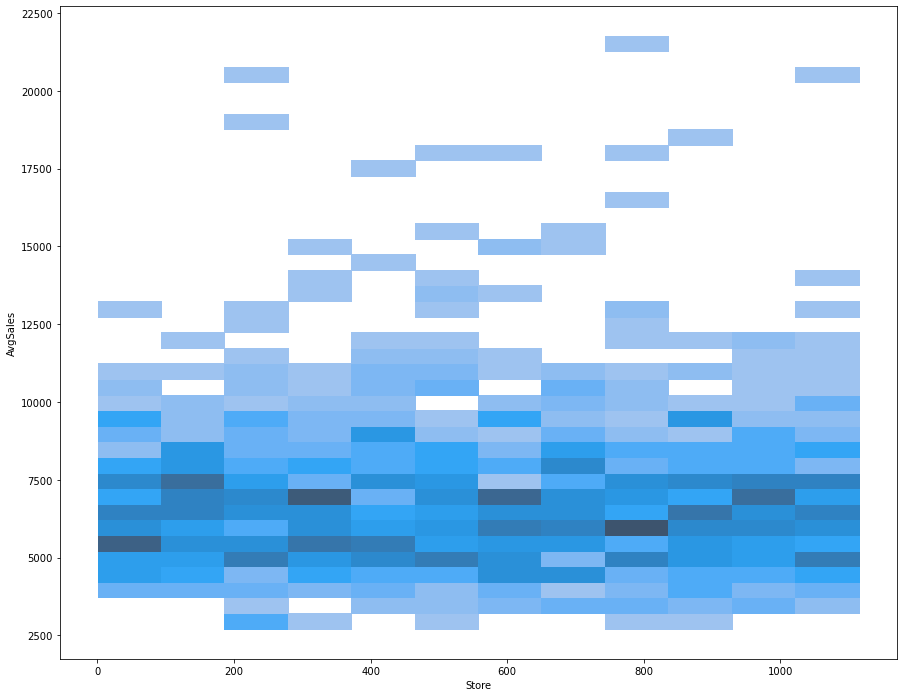

In [88]:

sns.histplot(x='Store', y='AvgSales', data=merge)

# ♪モデルの構築と評価

In [90]:
merge.columns

Index(['Store', 'MedSales_x', 'MedCustomers_x', 'MedSalesPerCustomer_x',
       'MedSales_y', 'MedCustomers_y', 'MedSalesPerCustomer_y', 'AvgSales',
       'AvgCustomers', 'AvgSalesPerCustomer', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [114]:
from sklearn.model_selection import train_test_split
X = [
    'Store', 
    'Customers',
    'CompetitionDistance', 

    'Promo', 
    'Promo2', 

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

    
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',
    
    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

]
X_data = merged[X]
Y_data = np.log(merged['Sales'])
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.20, random_state=10)

In [115]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error

def plot_importtance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])
    
    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X), vals, align='center'))
    plt.yticks(np.arange(len(Y), labels))

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param ={
            'n_estimators': [100,500, 1000,1500],
            'max_depth':[2,4,6,8]
        }

xgboost_tree = xgb.XGBRegressor(
    eta = 0.1,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)

grid = GridSearchCV(estimator=xgboost_tree,param_grid=param,cv=5,  verbose=1, n_jobs=-1,scoring='neg_mean_squared_error')
   
    

    
grid_result = grid.fit(X_train, y_train)
best_params = grid_result.best_params_

print('Best Params :',best_params)


In [ ]:
from math import sqrt

pred = grid_result.predict(X_test)
print('Root Mean squared error {}'.format(sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))))